In [1]:
import csv 
import os
import numpy as np
import random
from sklearn.metrics import roc_curve
import math
from matplotlib import pyplot
import datetime
from sklearn.metrics import auc, roc_curve, roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt
from dateutil.parser import parse 
import matplotlib as mpl
import seaborn as sns
from pandas import DataFrame
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from scipy.signal import find_peaks
import plotly.graph_objects as go
from scipy import fft
from scipy import signal as sig
from scipy.stats import multivariate_normal
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import f1_score
from numpy import arange
from math import sqrt
from numpy import argmax
import random as rn
import h2o
from sklearn.metrics import accuracy_score
import seaborn as sb
from sklearn.metrics import precision_recall_curve
sb.set_style(style="whitegrid")
sb.set_color_codes()
import scipy.ndimage
from scipy.fftpack import rfft, irfft, fftfreq, fft, ifft

In [2]:
df = pd.read_csv("F://phd//URC data//112_UCR_Anomaly_BIDMC1_2500_5400_5600.csv")
scaler = preprocessing.StandardScaler()
trainX=df[0:2500]
testX=df[5000:6000]
testXo=testX
trainX=scaler.fit_transform(trainX)
testX=scaler.fit_transform(testX)

In [3]:
dftotal = pd.DataFrame(trainX) 

dftotal.insert(0, 'id', range(1, 1 + len(dftotal)))

dftest = pd.DataFrame(testX) 

dftest.insert(0, 'id', range(1, 1 + len(dftest)))


<Figure size 3600x3600 with 0 Axes>

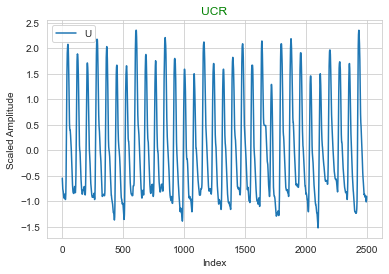

In [4]:
UCR = DataFrame(dftotal.values[:,0:2])
Utest = DataFrame(dftest.values[:,0:2])
residuals = pd.DataFrame(UCR.values[:,1:2])
restest = pd.DataFrame(Utest.values[:,1:2])
plt.figure( figsize=(50, 50) )
residuals.plot()
plt.xlabel('Index') 
plt.ylabel('Scaled Amplitude') 
plt.title("UCR", color='green')
plt.legend('UCR')
plt.show()




In [5]:

import statsmodels
from statsmodels.tsa.stattools import adfuller
class StationarityTests:
    def __init__(self, significance=.05):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None
    def ADF_Stationarity_Test(self, timeseries, printResults = True):
        #Dickey-Fuller test:
        adfTest = adfuller(timeseries)
        
        self.pValue = adfTest[1]
        
        if (self.pValue<self.SignificanceLevel):
            self.isStationary = True
        else:
            self.isStationary = False
        
        if printResults:
            dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
            #Add Critical Values
            for key,value in adfTest[4].items():
                dfResults['Critical Value (%s)'%key] = value
            print('Augmented Dickey-Fuller Test Results:')
            print(dfResults)
sTest = StationarityTests()
            

# KPSS Test
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw,nlags=len(series)-1)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')



In [6]:
sTest.ADF_Stationarity_Test(residuals, printResults = True)
print("Is the time series stationary? {0}".format(sTest.isStationary))
kpss_test(residuals)


Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -1.410631e+01
P-Value                 2.565841e-26
# Lags Used             2.300000e+01
# Observations Used     2.476000e+03
Critical Value (1%)    -3.432994e+00
Critical Value (5%)    -2.862708e+00
Critical Value (10%)   -2.567392e+00
dtype: float64
Is the time series stationary? True
KPSS Statistic: 0.5000000000000436
p-value: 0.041666666666656846
num lags: 2499
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


(0.0, 3500.0)

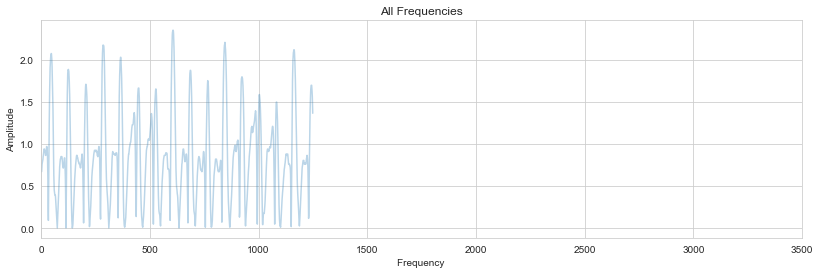

In [7]:
from scipy import fft
fft_output = fft.rfft(residuals)
power = np.abs(fft_output)
freq = fft.fftfreq(len(residuals),d=1/2500)
mask = freq >= 0
freq = freq[mask]
power = power[mask]
plt.figure( figsize=(30, 4) )
ax1 = plt.subplot( 1, 2, 2 )
ax1.plot(freq[2:], power[2:], label='signal', alpha=0.3)
ax1.set_title('All Frequencies')
ax1.set_ylabel( 'Amplitude' )
ax1.set_xlabel( 'Frequency ' )
ax1.set_xlim([0, 3500])

Text(0, 0.5, 'Autocorrelation')

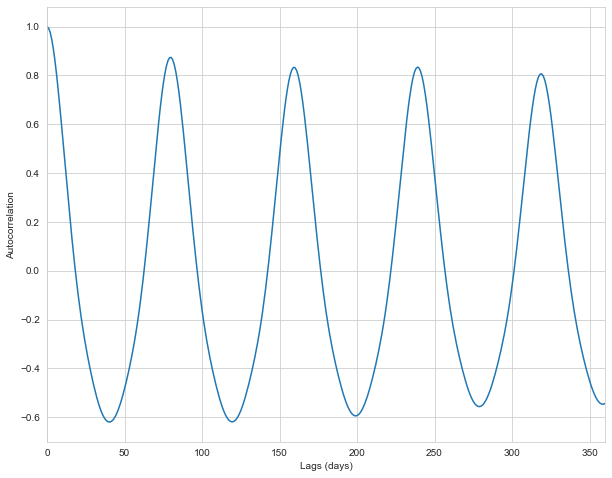

In [8]:
 # Periodicity of the two trajectories
from statsmodels import api as sm
# convert dataframe to array
np_df= np.asarray(residuals, dtype=float)
#np_df= np.asarray(level.values[:,1:2], dtype=float)
# remove mean to create signal oscillating around 0
np_df= np_df- np.mean(np_df)
#get the autocorrelation coefficient
acf= sm.tsa.acf(np_df, nlags=len(np_df),fft=True)

plt.figure(figsize = (10, 8))
lag = np.arange(len(np_df)) 
plt.plot(lag, acf)
plt.xlim((0, 360))
plt.xlabel('Lags (days)')
plt.ylabel('Autocorrelation')

In [9]:
import h2o
from h2o.estimators import H2OExtendedIsolationForestEstimator
h2o.init()



Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.321-b07, mixed mode)
  Starting server from C:\Users\khattab\Anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\khattab\AppData\Local\Temp\tmp6u8_4dad
  JVM stdout: C:\Users\khattab\AppData\Local\Temp\tmp6u8_4dad\h2o_khattab_started_from_python.out
  JVM stderr: C:\Users\khattab\AppData\Local\Temp\tmp6u8_4dad\h2o_khattab_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,05 secs
H2O_cluster_timezone:,Africa/Cairo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.0.2
H2O_cluster_version_age:,2 months and 8 days
H2O_cluster_name:,H2O_from_python_khattab_2gwmb3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.749 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [10]:
testX= h2o.H2OFrame(testX)


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


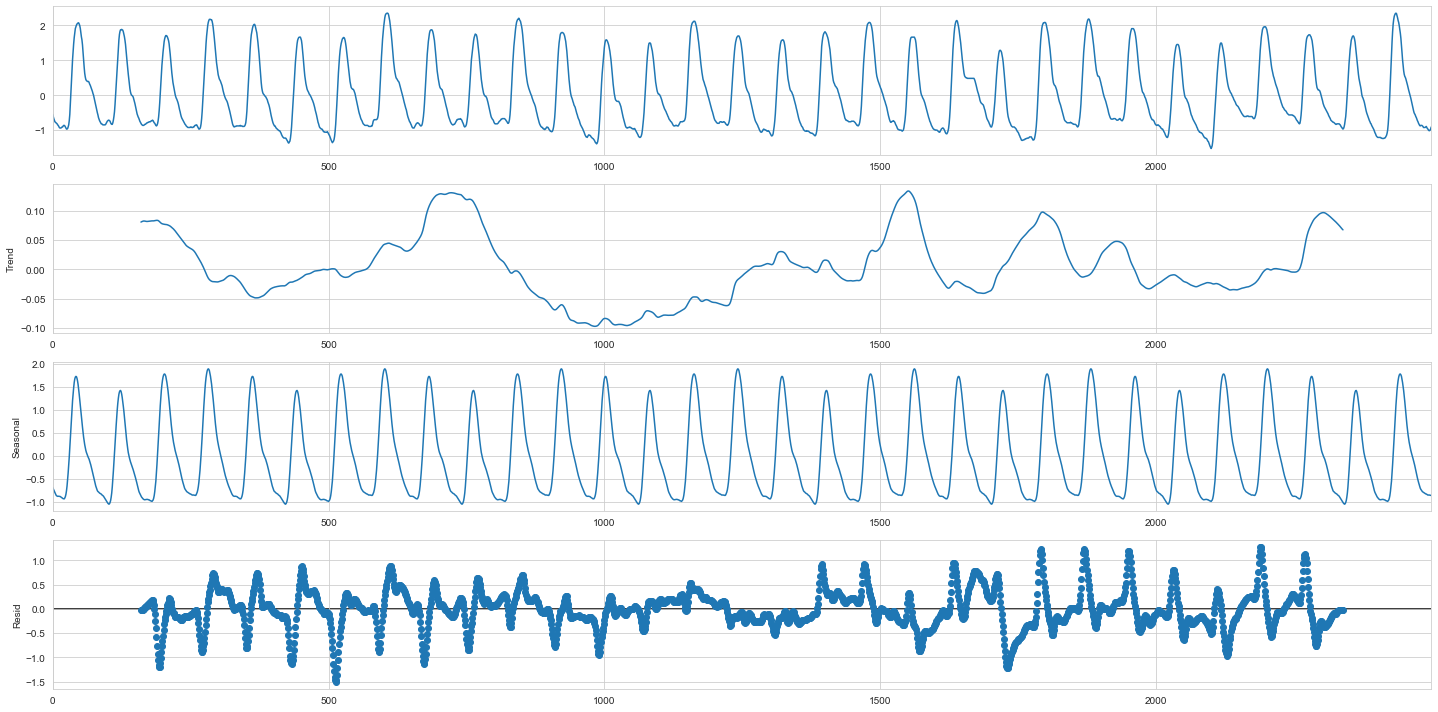

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [11]:
result_add = seasonal_decompose(residuals, model='additive', period=320)

plt.rcParams.update({'figure.figsize': (20,10)})
#result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('', fontsize=24)
plt.show()

res= np.nan_to_num(result_add.resid)
trend = np.nan_to_num(result_add.trend)
levelframe = h2o.H2OFrame(res)
leveltrend = h2o.H2OFrame(trend)




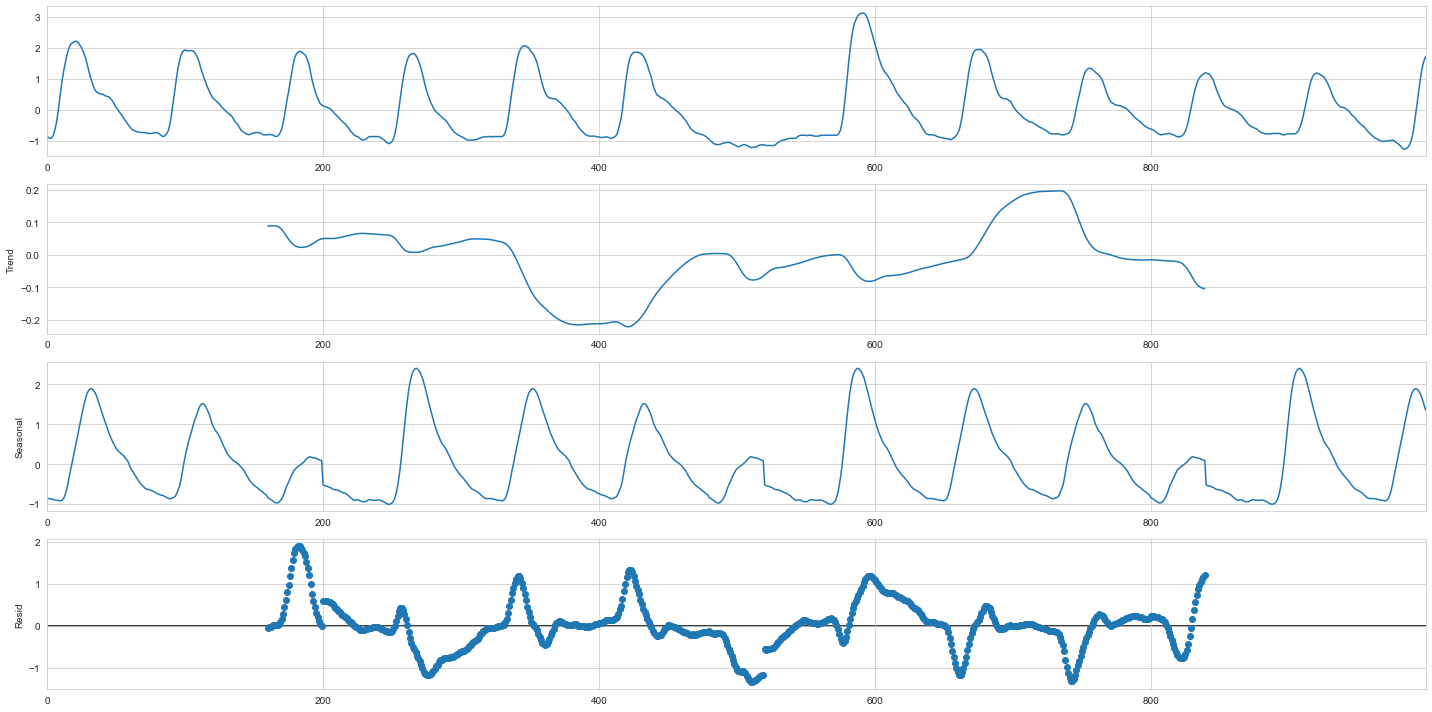

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [12]:
result_add = seasonal_decompose(restest, model='additive', period=320)

plt.rcParams.update({'figure.figsize': (20,10)})
#result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('', fontsize=24)
plt.show()

retest = np.nan_to_num(result_add.resid)
trend = np.nan_to_num(result_add.trend)
testframe = h2o.H2OFrame(restest)
testtrend = h2o.H2OFrame(trend)

In [13]:

powerres = levelframe
#levelframe=levelframe.cbind(leveltrend)
#levelframe=levelframe.cbind(powerres)
#levelframe=levelframe.fillna()
#powerres=powerres.cbind(leveltrend)

predictors =powerres.col_names

print(predictors)
# Define an Extended Isolation forest model
eif = H2OExtendedIsolationForestEstimator(ntrees =300,
                                          sample_size = 26)

# Train Extended Isolation Forest
eif.train(x = predictors, training_frame = powerres)
#powertest = h2o.H2OFrame(powertest)
#powertest=powertest.cbind(testtrend)
#testframe=testframe.cbind(testtrend)
#stframe=testframe.cbind(powertest)
# Calculate score
eif_result = eif.predict(testframe.fillna())


anomaly_score = eif_result["anomaly_score"]
print(len(anomaly_score))

# Average path length  of the point in Isolation Trees from root to the leaf
mean_length = eif_result["mean_length"]



['C1']
extendedisolationforest Model Build progress: |██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
1000


In [14]:
dd=h2o.as_list(anomaly_score)
ff = np.zeros(len(testX))
for i in range(400, 600):
    ff[i]=1
ff=h2o.as_list(h2o.H2OFrame(ff))
fpr, tpr, thresholds = roc_curve(ff["C1"],dd)

print(roc_auc_score( ff["C1"],dd))
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
0.6293
Threshold value is: 0.5968194048659842


In [15]:
testlevel=pd.DataFrame(ff["C1"],columns=["C1"])
typlevel=pd.DataFrame(dd,columns=["mean_length"])
optimal_cond=optimal_threshold



for j in range(len(typlevel)):
 #typlevel[j]["mean_length"] 
 if typlevel["mean_length"][j]>=optimal_threshold:
   typlevel["mean_length"][j]=1
 else:
   typlevel["mean_length"][j]  = 0


In [16]:
score = f1_score ( np.array(testlevel.values[:]),np.array(typlevel.values[:]))
score2=accuracy_score(np.array(testlevel.values[:]),np.array(typlevel.values[:]), normalize=True)
score3=accuracy_score(np.array(testlevel.values[:]),np.array(typlevel.values[:]), normalize=False)
print('F1 Score: %.3f' % score)
print('accuracy_score normalize: %.3f' % score2)
print('accuracy_score not normalize: %.3f' % score3)


F1 Score: 0.000
accuracy_score normalize: 0.800
accuracy_score not normalize: 800.000


In [17]:
testXo.insert(0, 'id', range(1, 1 + len(testXo)))
x=(testXo.values[:,0:1])
y=(testXo.values[:,1:2])
z=typlevel

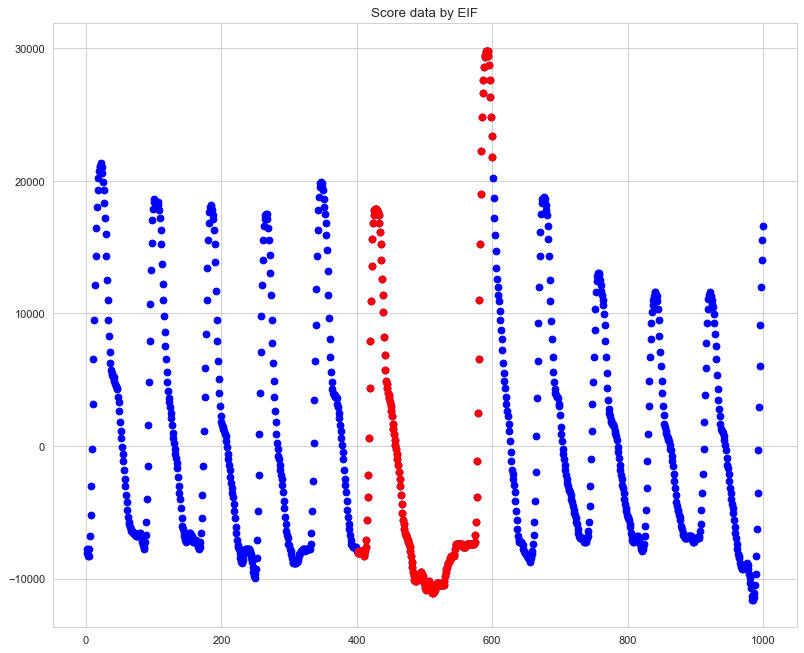

In [18]:
r=ff
plt.figure(figsize=(12, 10), dpi=80)
plt.scatter(x,y,color='blue')

plt.scatter(x[r[:]>=1],y[r[:]>=1],c='red')

plt.title('Score data by EIF')
plt.show()


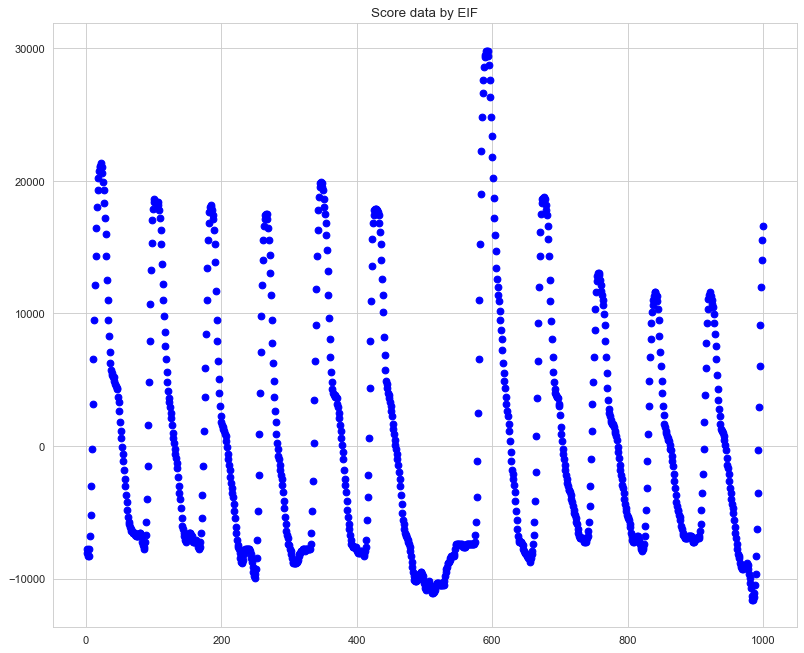

In [19]:
plt.figure(figsize=(12, 10), dpi=80)
plt.scatter(x,y.flatten(),color='blue')
plt.scatter(x[z[:]>optimal_threshold/10],y[z[:]>optimal_threshold/10],c='red')

plt.title('Score data by EIF')
plt.show()


In [20]:


fft_UCR = fft.rfft(UCR.values[:,1:2])
powerUCR = np.abs(fft_UCR)

freqUCR = fft.fftfreq(len(UCR.values[:,1:2]),d=1/2500)



In [21]:

fft_Utest = fft.rfft(Utest.values[:,1:2])
powerUtest = np.abs(fft_Utest)

freqUtest = fft.fftfreq(len(Utest.values[:,1:2]),d=1/1000)



(0.0, 1400.0)

<Figure size 1440x720 with 0 Axes>

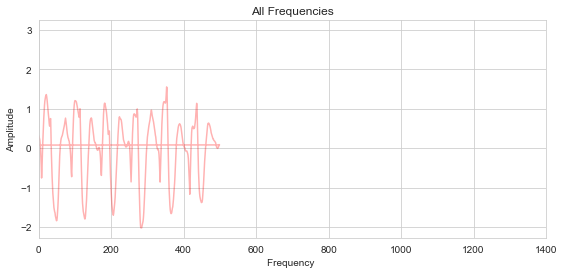

In [22]:
import scipy as sp 
def get_top_n_frequencies(n, freqs, amplitudes, min_amplitude_threshold = None):
    '''
    Gets the top N frequencies: a sorted list of tuples (freq, amplitudes)
    
    
    
    '''
    
    #print(amplitudes)
    if min_amplitude_threshold is not None:
        amplitude_indices = np.where(amplitudes >= min_amplitude_threshold)
        amplitudes = amplitudes[amplitude_indices]
        freqs = freqs[amplitude_indices]
        
    if n < len(amplitudes):
        ind = np.argpartition(amplitudes, -n)[-n:] # from https://stackoverflow.com/a/23734295
        ind_sorted_by_coef = ind[np.argsort(-amplitudes[ind])] # reverse sort indices
    else:
        ind_sorted_by_coef = np.argsort(-amplitudes)

    return_list = list(zip(freqs[ind_sorted_by_coef], amplitudes[ind_sorted_by_coef]))
    return return_list
def get_top_n_frequency_peaks(n, freqs, amplitudes, min_amplitude_threshold = None):
    ''' Finds the top N frequencies and returns a sorted list of tuples (freq, amplitudes) '''
    
    # Use SciPy signal.find_peaks to find the frequency peaks
    # TODO: in future, could add in support for min horizontal distance so we don't find peaks close together
    fft_peaks_indices, fft_peaks_props = sp.signal.find_peaks(amplitudes, height = min_amplitude_threshold)
    
    freqs_at_peaks = freqs[fft_peaks_indices]
    amplitudes_at_peaks = amplitudes[fft_peaks_indices]
    
    if n < len(amplitudes_at_peaks):
        ind = np.argpartition(amplitudes_at_peaks, -n)[-n:] # from https://stackoverflow.com/a/23734295
        ind_sorted_by_coef = ind[np.argsort(-amplitudes_at_peaks[ind])] # reverse sort indices
    else:
        ind_sorted_by_coef = np.argsort(-amplitudes_at_peaks)

    return_list = list(zip(freqs_at_peaks[ind_sorted_by_coef], amplitudes_at_peaks[ind_sorted_by_coef]))
    return return_list
#print(get_top_n_frequency_peaks(10,np.ravel(freq[0:500]),np.ravel(power[0:500])))
#print(get_top_n_frequencies(10,np.ravel(freq[0:500]),np.ravel(power[0:500])))
correlate_result = np.correlate(np.ravel(UCR.values[0:1000,1:2]), np.ravel(Utest.values[0:1000,1:2]) , 'full')
#print(correlate_result)      
plt.figure(0)
plt.figure( figsize=(20, 4) )
ax1 = plt.subplot( 1, 2, 2 )
 

#ax1.plot(freq[0:], power[0:], label='signal',color='green', alpha=0.3)
#ax1.plot(freq[0:500], correlate_result[0:500], label='signal',color='red', alpha=0.3)
ax1.plot(freqUtest[0:1000],(powerUtest[0:1000]-powerUCR[0:1000]), label='signal',color='red', alpha=0.3)

#plt.figure(1)
#ax1.plot(freq[2:250], sh[2:250], label='signal',color='green', alpha=0.3)
#ax1.plot(freq2[2:250]+20, sh2[2:250], label='signal',color='red', alpha=0.3)
ax1.set_title('All Frequencies')
ax1.set_ylabel( 'Amplitude' )
ax1.set_xlabel( 'Frequency ' )
ax1.set_xlim([0, 1400])




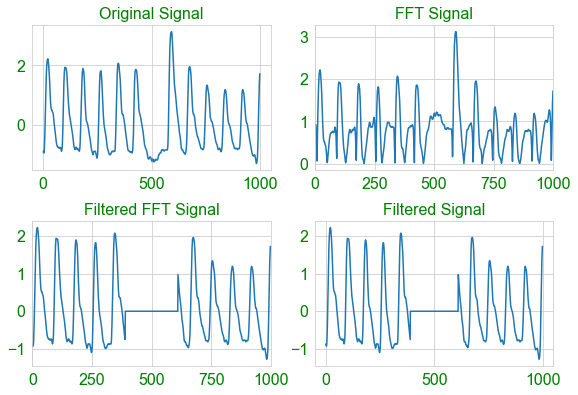

In [23]:



import matplotlib as mpl

#===========================================
#GETTING DATA AND SETTING CONSTANTS
#===========================================




f_signal = rfft(Utest.values[:,1:2])

freq = fftfreq(len(Utest.values[:,1:2]),d=1/1000)

#=============================================
#THE FFT TRANSFORM & FILTERING
#=============================================
#signal filtering
freqmin = 400
freqmax = 600


cut_f_signal = f_signal.copy()

cut_f_signal[(freq>=390)|(freq<=-390)  ] = 0
cut_signal = irfft(cut_f_signal)


plt.figure(figsize=(8,8))

ax1 = plt.subplot(321)
ax1.plot(Utest.values[:,1:2])
ax1.set_title("Original Signal", color='green', fontsize=16)

ax2 = plt.subplot(322)
ax2.plot(np.abs(f_signal))
plt.xlim(0,1000)
ax2.set_title("FFT Signal", color='green', fontsize=16)

ax3 = plt.subplot(323)
ax3.plot(cut_f_signal)
plt.xlim(0,1000)
ax3.set_title("Filtered FFT Signal", color='green', fontsize=16)

ax4 = plt.subplot(324)
ax4.plot(cut_signal)

ax4.set_title("Filtered Signal", color='green', fontsize=16)

for i in [ax1,ax2,ax3,ax4]:
    i.tick_params(labelsize=16, labelcolor='green')

plt.tight_layout()
plt.show()

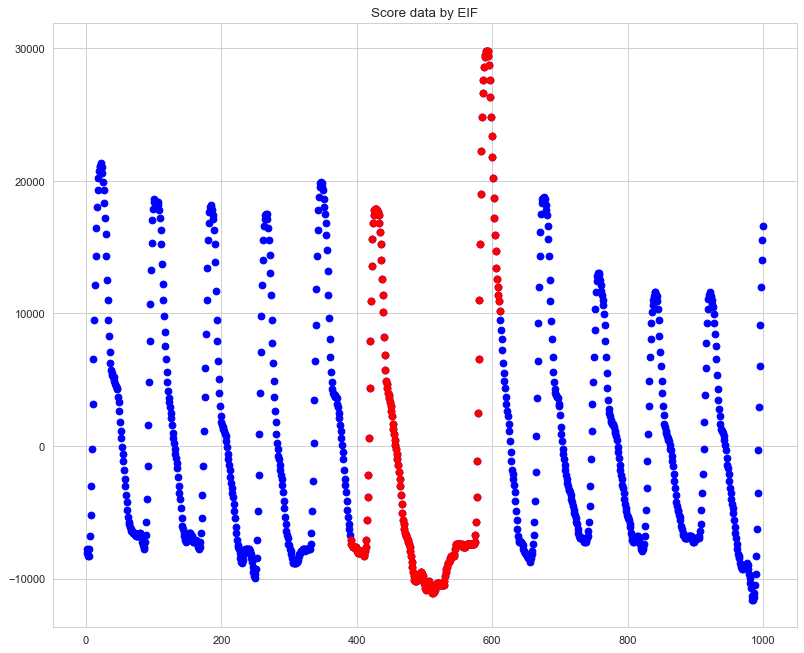

In [24]:
z=cut_signal
plt.figure(figsize=(12, 10), dpi=80)
plt.scatter(x,y.flatten(),color='blue')
plt.scatter(x[z[:]==0],y[z[:]==0],c='red')

plt.title('Score data by EIF')
plt.show()

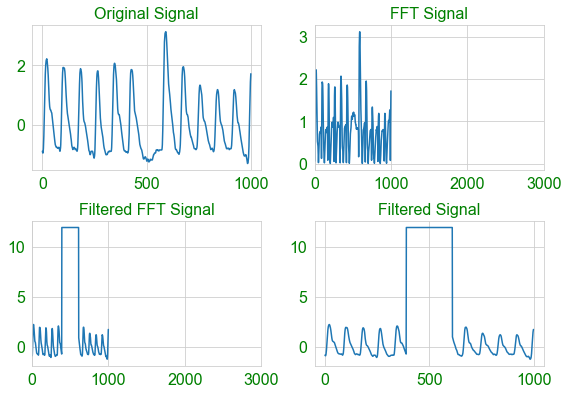

In [25]:

from scipy.fftpack import rfft, irfft, fftfreq, fft, ifft
import matplotlib as mpl

#===========================================
#GETTING DATA AND SETTING CONSTANTS
#===========================================



f_signal = rfft(Utest.values[:,1:2])


freqy = fftfreq(len(Utest.values[:,1:2]),d=1/800)

#THE FFT TRANSFORM & FILTERING
#=============================================
#signal filtering
freqmin = 400
freqmax = 600


cut_f_signal = f_signal.copy()

cut_f_signal[(freq>=390)|(freq<=-390)  ] = 12
cut_signal = irfft(cut_f_signal)


plt.figure(figsize=(8,8))

ax1 = plt.subplot(321)
ax1.plot(Utest.values[:,1:2])
ax1.set_title("Original Signal", color='green', fontsize=16)

ax2 = plt.subplot(322)
ax2.plot(np.abs(f_signal))
plt.xlim(0,3000)
ax2.set_title("FFT Signal", color='green', fontsize=16)

ax3 = plt.subplot(323)
ax3.plot(cut_f_signal)
plt.xlim(0,3000)
ax3.set_title("Filtered FFT Signal", color='green', fontsize=16)

ax4 = plt.subplot(324)
ax4.plot(cut_signal)

ax4.set_title("Filtered Signal", color='green', fontsize=16)

for i in [ax1,ax2,ax3,ax4]:
    i.tick_params(labelsize=16, labelcolor='green')

plt.tight_layout()
plt.show()

In [26]:
dd2 =  np.zeros(len(Utest.values[:,1:2]))
z=cut_signal


for i in range(0, len(Utest.values[:,1:2])):
 
 if z[i]==12:
    dd2[i]=1
 else:
    dd2[i]=0




#dd=(np.array(dd2, dtype=bool))

#dd=dd[:,0:1]
fpr, tpr, thresholds = roc_curve(ff,dd2)

print(roc_auc_score(np.array( ff["C1"], dtype=bool),dd2))
optimal_idx = np.argmax(tpr - fpr)

score = f1_score (ff,dd2)
score2=accuracy_score(dd2,np.array( ff["C1"], dtype=bool), normalize=True)
score3=accuracy_score(dd2,np.array( ff["C1"], dtype=bool), normalize=False)
print('F1 Score: %.3f' % score)
print('accuracy_score normalize: %.3f' % score2)
print('accuracy_score not normalize: %.3f' % score3)


0.9868750000000001
F1 Score: 0.950
accuracy_score normalize: 0.979
accuracy_score not normalize: 979.000
